# Simulated IRT Data Generation
To test our non-parametric IRT model, we generate items with a parameteric form and sample student abilities from the standard prior distributions assumed in IRT literature, because these at least have some history/credibility as model data.

In [23]:
# Simulate MCMC model data: pick the true parameter variables from the model's prior distribution.
import cluster.cntree.cntree as cntree
import logging
import matplotlib.pyplot as plt
import nirt.simulate.simulate_data
import numpy as np
import numpy.matlib
import sklearn.cluster
from numpy.linalg import norm, svd

%load_ext autoreload
%autoreload 2

level = logging.INFO
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(level=level, format="%(levelname)-8s %(message)s", datefmt="%a, %d %b %Y %H:%M:%S")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
# Number of persons.
P = 1000
# Number of items.
I = 20
# Number of latent ability dimensions (sub-scales).
C = 5
# Fixed item asymptote (pi) as theta -> -\infty = probability of guessing.
asym = 0.25

In [226]:
X, theta = nirt.simulate.simulate_data.generate_simulated_data(P, I, C, asym)

[0.26 6.68 0.39 1.42 1.93]


(1000, 5)


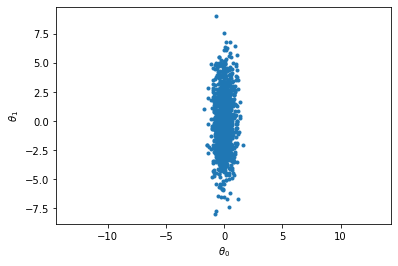

In [227]:
# Verify that student latent abilities are normally distributed. theta_c ~ N(0, invgamma(a_c,b_c))
print(theta.shape)
plt.plot(theta[:,0], theta[:,1], '.')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.axis('equal')
plt.show()

## Item Clustering into Classes
We use k-means with abs cosine distance (generally, over the set of persons that answered the two items between which the distance is measured; this only approximately satisfies the triangle inequality, but approximately enough for large $P$) to cluster items into $C$ dimensions.

In [30]:
kmeans = sklearn.cluster.KMeans(n_clusters=C, random_state=0).fit(X.transpose())
print(kmeans.labels_)
#print(kmeans.cluster_centers_)
#print(kmeans.n_iter_)
#print(kmeans.inertia_)

[2 4 2 3 2 3 2 4 1 2 1 1 0 0 1 1 1 1 0 1]


This shows that it's not easy to recover the $C$ classes from responses, since items that measure the same dimension are not necessarily highly correlated. For now, we will assume the apriori knownledge of $c$, the correspondence between items and dimensions. 

## Person Sampling

In [228]:
clustering = nirt.simulate.simulate_data.cluster_persons(X, C)

INFO     Level	Nbhrs	Size	cr	mean_sz	std_sz	Time
INFO     1    	2    	2    	500.00 	500.0  	11.0   	0.04
INFO     2    	4    	4    	250.00 	250.0  	14.6   	0.02
INFO     3    	7    	8    	125.00 	125.0  	14.3   	0.01
INFO     4    	7    	16   	62.50  	62.5   	8.2    	0.01
INFO     5    	7    	32   	31.25  	31.2   	5.5    	0.01
INFO     6    	7    	64   	15.62  	15.6   	3.6    	0.01
INFO     7    	7    	128  	7.81   	7.8    	2.3    	0.02
INFO     8    	7    	256  	3.91   	3.9    	1.5    	0.03
INFO     9    	7    	470  	2.13   	2.1    	0.9    	0.05
INFO     10   	7    	593  	1.69   	1.7    	0.6    	0.07
INFO     11   	7    	613  	1.63   	1.6    	0.5    	0.06
INFO     12   	7    	615  	1.63   	1.6    	0.5    	0.04
INFO     Total						0.39
INFO     Trimming #neighbors to 5


In [204]:
# Generate group-level scores by averaging over children groups.

import scipy.sparse

class FinestLevel: pass
f = FinestLevel
f._parent_of=child.label
f.cluster_size=np.ones(X.shape[0])
f.size=X.shape[0]
levels = cntree.get_clustering_levels(clustering) + [f]

In [205]:
S = len(levels)-1
print('S', S)
X_level = [None] * (S+1)
R = [None] * (S+1)
X_level[S] = X
for s in range(S-1, -1, -1):
    parent = levels[s]
    child = levels[s+1]
    membership = scipy.sparse.csr_matrix((np.ones(child.size), (child._parent_of, np.arange(child.size))), shape=(parent.size, child.size))
    child_size = scipy.sparse.diags([child.cluster_size], [0])
    parent_size = scipy.sparse.diags([1 / parent.cluster_size], [0])
    R[s] = parent_size.dot(membership.dot(child_size))
    print(X_level[s+1].shape, R[s].shape)
    X_level[s] = R[s].dot(X_level[s+1])
    #print(R.sum(axis=1))
    
for s in range(S+1):
    print(s, R[s].shape if R[s] is not None else '-', X_level[s].shape)

S 9
(100, 20) (65, 100)
(65, 20) (64, 65)
(64, 20) (57, 64)
(57, 20) (32, 57)
(32, 20) (16, 32)
(16, 20) (8, 16)
(8, 20) (4, 8)
(4, 20) (2, 4)
(2, 20) (1, 2)
0 (1, 2) (1, 20)
1 (2, 4) (2, 20)
2 (4, 8) (4, 20)
3 (8, 16) (8, 20)
4 (16, 32) (16, 20)
5 (32, 57) (32, 20)
6 (57, 64) (57, 20)
7 (64, 65) (64, 20)
8 (65, 100) (65, 20)
9 - (100, 20)


In [224]:
from functools import reduce

np.set_printoptions(linewidth=1000, threshold=10000, precision=2)
s = 1
parent = levels[s]
child = levels[s+1]
membership = scipy.sparse.csr_matrix((np.ones(child.size), (child._parent_of, np.arange(child.size))), shape=(parent.size, child.size))
child_size = scipy.sparse.diags([child.cluster_size], [0])
parent_size = scipy.sparse.diags([1 / parent.cluster_size], [0])
R[s] = parent_size.dot(membership.dot(child_size))

print(child.cluster_size)
print(parent.cluster_size)
print(child._parent_of)
print(parent._children_of)
print(parent._num_children)
for k in range(parent.size):
    print(k)
    a = sorted(reduce(np.union1d, (child.cluster_members(c) for c in parent._children_of[k])))
    b = sorted(parent.cluster_members(k))
    print([np.sort(child.cluster_members(c)) for c in parent._children_of[k]])
    print(b)
    print(a == b)
#print(membership.todense())
print(parent._start)
print(parent._point_index)

[28 25 20 27]
[53 47]
[0 0 1 1]
[[0 1]
 [2 3]]
[2 2]
0
[array([ 5,  9, 13, 19, 21, 27, 31, 35, 37, 39, 44, 47, 52, 54, 61, 62, 65, 74, 79, 80, 84, 85, 87, 93, 94, 95, 96, 97]), array([ 0,  2,  3,  4, 10, 17, 26, 29, 33, 36, 41, 45, 51, 53, 55, 60, 67, 69, 70, 73, 77, 78, 83, 86, 90])]
[0, 2, 3, 4, 5, 7, 9, 10, 11, 13, 17, 19, 21, 26, 27, 29, 31, 33, 36, 37, 39, 44, 45, 47, 52, 53, 54, 55, 57, 60, 61, 62, 65, 67, 69, 70, 73, 74, 77, 78, 79, 80, 83, 84, 85, 86, 87, 90, 93, 94, 95, 96, 97]
False
1
[array([ 1,  7, 14, 15, 16, 18, 20, 28, 30, 46, 56, 57, 64, 71, 72, 75, 82, 88, 89, 98]), array([ 6,  8, 11, 12, 22, 23, 24, 25, 32, 34, 38, 40, 42, 43, 48, 49, 50, 58, 59, 63, 66, 68, 76, 81, 91, 92, 99])]
[1, 6, 8, 12, 14, 15, 16, 18, 20, 22, 23, 24, 25, 28, 30, 32, 34, 35, 38, 40, 41, 42, 43, 46, 48, 49, 50, 51, 56, 58, 59, 63, 64, 66, 68, 71, 72, 75, 76, 81, 82, 88, 89, 91, 92, 98, 99]
False
[  0  53 100]
[ 0 31 33 80 36 37 79 39 78 77 44 45 74 47 73 70 52 53 54 55 69 57 67 60 61 62 83 29 65

In [137]:
X_level[0]

array([[0.36, 0.33, 0.5 , 0.48, 0.51, 0.45, 0.46, 0.44, 0.52, 0.63, 0.66, 0.75, 0.69, 0.66, 0.87,
        0.88, 0.83, 0.88, 0.84, 0.9 ]])

In [ ]:
import pandas as pd
pd.options.display.width = 1000
pd.options.display.precision = 3
j = np.where(c == 0)[0]
k = np.where(c == 1)[0]
i = np.concatenate((j, k))
print(j)
print(k)
xi = pd.DataFrame(X[:,i])
xi.corr()

In [ ]:
tree = cntree.CNTree(max_levels=20, max_cluster_radius=max_cluster_radius, max_cluster_size=max_cluster_size, metric="abs_cos2", debug=1)
clustering = tree.cluster(y_normalized)


In [ ]:
u, s, vh = svd(X)

In [ ]:
plt.plot(s, 'bo-')

In [ ]:
print(vh.shape)
for r in range(1, X.shape[1] + 1, 5):
    P = vh[:r].transpose()
    print(r, norm(X - (X.dot(P)).dot(P.transpose())) / norm(X))

r = 5
P = vh[:r].transpose()
t = X.dot(P)
X_reconstructed = t.dot(P.transpose())
print(X.shape, P.shape, XC.shape)
print(P[:3])
print(t[:4])
print(X[3:])
print(X_reconstructed[3:])

# Initial Guess for $\theta$

In [ ]:
# Initial guess for theta_p^c: fraction of correct responses of person p to items measuring
# sub-scale c.
theta_init = np.array([np.mean(X[:, np.where(c == d)[0]], axis=1) for d in range(C)])

In [ ]:
np.mean(t, axis=0)

In [ ]:
np.mean(X, axis=0)